In [ ]:
# %%capture
import sys
!conda install --yes --prefix {sys.prefix} ipympl
import pystac_client
import planetary_computer
import rioxarray as rio
import xarray as xr
import numpy as np
import leafmap
import matplotlib as mpl
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import geopandas as gpd
from shapely.geometry import shape, LineString, MultiLineString
from skimage.measure import find_contours

In [162]:
m = leafmap.Map(center = [48, 3], zoom = 10, widescreen = False)
m.add_basemap('HYBRID')
m

Map(center=[48, 3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

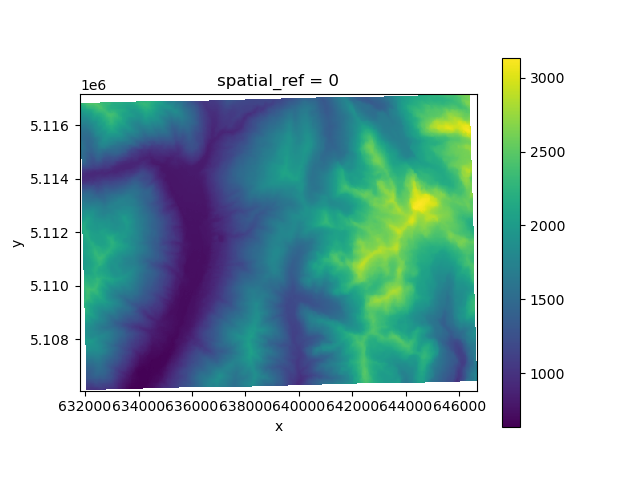

In [163]:
%matplotlib widget
roi = m.draw_features[0]['geometry']
roi = gpd.GeoDataFrame(geometry = [shape(roi)], crs = 4326)

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace)

search = catalog.search(collections=["cop-dem-glo-30"],
                        intersects=roi.geometry[0])
items = list(search.get_items())

signed_asset = planetary_computer.sign(items[0].assets["data"])
data = (rio.open_rasterio(signed_asset.href)
        .squeeze()
        .drop("band"))

dem = data.rio.clip(roi.geometry)
roi_local = roi.to_crs(roi.estimate_utm_crs())
res = 30
dem_local = dem.rio.reproject(roi_local.crs, resolution = res)
dem_local = (xr.where(dem_local > 1e10, np.nan, dem_local)).rio.set_crs(roi_local.crs)

# fig, ax = plt.subplots()
# dem_local.plot(cmap = 'viridis',
#                vmin = dem_local.min().round()-1,
#                vmax = dem_local.max().round()+1,
#                ax = ax)
# ax.set_aspect('equal')

0

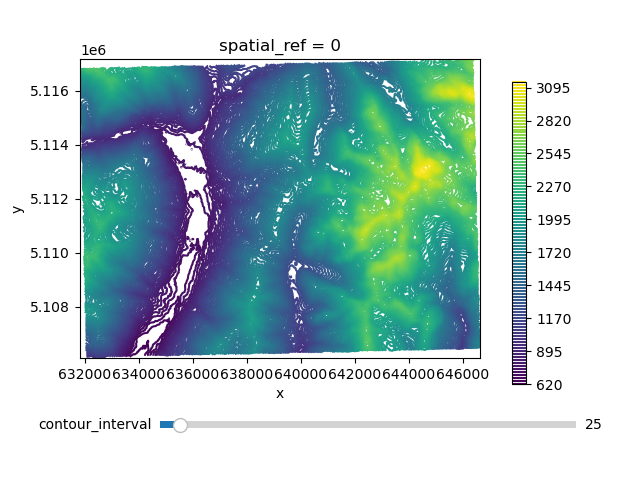

In [178]:
minz = np.round(dem_local.min()-10, -1)
maxz = np.round(dem_local.max(),-1)
interval = 25
levels = np.arange(minz, maxz+interval, interval)

fig, ax = plt.subplots()
qc = xr.plot.contour(dem_local, levels = levels,
                         cmap = 'viridis',
                         add_colorbar = False,
                         vmin = dem_local.min().round()-1,
                         vmax = dem_local.max().round()+1,
                         ax = ax)
ax.set_aspect('equal')
fig.subplots_adjust(right=0.75, bottom = 0.25)

# Make a vertically oriented slider to control the amplitude
ax_vertical = fig.add_axes([0.8, 0.2, 0.0225, 0.63])
plt.colorbar(qc, cax = ax_vertical)

ax_horizontal = fig.add_axes([0.25, 0.1, 0.65, 0.03])
level_slider = Slider(ax=ax_horizontal,
                      label="contour_interval",
                      valmin=1, valmax=np.round((maxz-minz) / 5,-1),
                      valinit=interval, valstep = np.concatenate([np.array([1,2,3]),np.arange(5,1000,5)]),
                      orientation="horizontal")

# The function to be called anytime a slider's value changes
def update(val):
    ax.clear()
    ax_vertical.clear()
    levels = np.arange(minz, maxz+interval, level_slider.val)
    qc = xr.plot.contour(dem_local, levels = levels,
                         cmap = 'viridis',
                         add_colorbar = False,
                         vmin = dem_local.min().round()-1,
                         vmax = dem_local.max().round()+1,
                         ax = ax)
    ax.set_aspect('equal')
    plt.colorbar(qc, cax = ax_vertical)
    fig.canvas.draw_idle()
    # print("level: \t", level_slider.val, "height intervals:\t", qc.cvalues)

# register the update function with each slider
level_slider.on_changed(update)

In [180]:
interval = level_slider.val
norm = Normalize(vmin = minz, vmax = maxz)
cmap = mpl.cm.Blues

lss = []
elevations = np.arange(minz,maxz+interval,interval)
# fig, ax = plt.subplots()
for h in elevations:
    fc = find_contours(dem_local.values, level = h)
    cs = []
    for c in fc:
        y = dem_local.y.max().values - c[:,0]*res
        x = c[:,1]*res + dem_local.x.min().values
        cs.append(LineString(zip(x,y)))     
        # ax.plot(*LineString(zip(x,y)).coords.xy, c = cmap(norm(h)))
    lss.append(MultiLineString(cs))
# ax.set_aspect('equal')

gdf = gpd.GeoDataFrame(data = {'elevation':elevations}, geometry = lss, crs = roi_local.crs)
gdf = gdf.loc[~gdf.geometry.is_empty]
gdf.explore(column = 'elevation')

In [186]:
gdf.to_file('contours.geojson',driver = 'GeoJSON')